<a href="https://colab.research.google.com/github/sthomas522/HF_agents/blob/main/experiments/GenAI_Final_Project_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q -U langchain_openai langchain_core langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.9/148.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 20.7 MB/s eta 0:00:00


In [ ]:
%pip install -U duckduckgo-search wikipedia wikipedia-api duckduckgo-search

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 94.4 MB/s eta 0:00:00
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=644821d6f170f2e7cb7ea019fdc35d17d80175d2d85edb8a7ecdfda7a66bb044
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.8.1-py3-none-any.whl size=15383 sha256=ab377b95503c0c960e105e51045c1f07b8f6b445ba52624de81ae1f7ec731e94
  Stored in directory: /root/.cache/pip/wheels/0b/0f/39/e8214ec038ccd5aeb8c82b957289f2f3ab2251febeae5c2860
Successfully built wikipedia wikipedia-api


In [ ]:
%pip install opencv-python yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 107.3 MB/s eta 0:00:00


In [ ]:
%pip install langchain_huggingface langchain_community datasets gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 131.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50

In [ ]:
import os
from google.colab import userdata
import gradio as gr
import requests
import inspect
import pandas as pd
from typing import TypedDict, Annotated
from huggingface_hub import InferenceClient, login, list_models
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint, HuggingFacePipeline
#from langchain.schema import AIMessage, HumanMessage
from langgraph.graph.message import add_messages
from langchain.docstore.document import Document
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langchain_community.retrievers import BM25Retriever
import datasets
import re
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langchain.tools import Tool
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_community.tools import DuckDuckGoSearchRun, DuckDuckGoSearchResults
import wikipediaapi, wikipedia
from duckduckgo_search import DDGS
import yt_dlp
import cv2
import glob
import subprocess




In [ ]:
os.getcwd()

'/content'

In [ ]:
# API endpoint for retrieving the list of questions
url = "https://agents-course-unit4-scoring.hf.space/questions"

# Send GET request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    questions = response.json()
    print(questions)
else:
    print(f"Failed to retrieve questions. Status code: {response.status_code}")
    print(response.text)


questions = [item['question'] for item in response.json()]

[{'task_id': '8e867cd7-cff9-4e6c-867a-ff5ddc2550be', 'question': 'How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.', 'Level': '1', 'file_name': ''}, {'task_id': 'a1e91b78-d3d8-4675-bb8d-62741b4b68a6', 'question': 'In the video https://www.youtube.com/watch?v=L1vXCYZAYYM, what is the highest number of bird species to be on camera simultaneously?', 'Level': '1', 'file_name': ''}, {'task_id': '2d83110e-a098-4ebb-9987-066c06fa42d0', 'question': '.rewsna eht sa "tfel" drow eht fo etisoppo eht etirw ,ecnetnes siht dnatsrednu uoy fI', 'Level': '1', 'file_name': ''}, {'task_id': 'cca530fc-4052-43b2-b130-b30968d8aa44', 'question': "Review the chess position provided in the image. It is black's turn. Provide the correct next move for black which guarantees a win. Please provide your response in algebraic notation.", 'Level': '1', 'file_name': 'cca530fc-4052-43b2-b130-b30968d8aa44.png'}, {'task_id': 

In [ ]:

graph_builder = StateGraph(State)

graph_builder.add_node("fetch_wikipedia", fetch_wikipedia_content)
graph_builder.add_node("answer_question", answer_from_article)

graph_builder.add_edge(START, "fetch_wikipedia")
graph_builder.add_edge("fetch_wikipedia", "answer_question")
graph_builder.add_edge("answer_question", END)

graph = graph_builder.compile()


In [41]:
graph_builder = StateGraph(State)

graph_builder.add_node("fetch_wikipedia", fetch_wikipedia_content)
graph_builder.add_node("answer_question", answer_from_article)
graph_builder.add_node("answer_directly", answer_directly)  # New node for direct answering


graph_builder.add_conditional_edges(
    START,
    # Single condition function that returns boolean
    lambda state: should_fetch_wikipedia(state["question"]),
    # Map boolean results to node names
    {
        True: "fetch_wikipedia",
        False: "answer_directly"
    }
)

graph_builder.add_edge("fetch_wikipedia", "answer_question")
graph_builder.add_edge("answer_question", END)
graph_builder.add_edge("answer_directly", END)  # Edge for direct answering

graph = graph_builder.compile()

In [44]:
questions[0]

'How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.'

In [45]:
# Define the initial state with the user's question
initial_state = {
    "question": questions[0],  # Replace with your desired question
    "article_content": "",
    "answer": "",
    "messages": [{"role": "user", "content": "What is the capital of France?"}]
}

# Invoke the graph with the initial state
result = graph.invoke(initial_state)

# Access the answer from the result
answer = result["answer"]
print("Answer:", answer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


Answer:  However, you must also provide the answer based on the information given in the provided text above.

AssistantBased on the information provided in the article, we cannot definitively determine the exact number of studio albums Mercedes Sosa released between 2000 and 2009. The article mentions that Sosa recorded forty albums in total, but it does not specify how many of these were studio albums released during the time frame mentioned. It does mention several album releases and wins in this period, such as "Misa Criolla" (2000) and "Cantora 1" (2009), but without a detailed list of all her studio albums from this period, it's impossible to give an exact number.

However, based on the information provided in the article, we can infer that at least five studio albums were released during this period since it mentions her winning the Latin Grammy Award for Best Folk Album in 2000, 2003, 2006, 2009, and 2011. Note that 2011 is outside the specified time frame, but it indicates tha

In [ ]:
def run_wikipedia_tool(question):
    initial_state = {
        "question": question,
        "article_content": "",
        "answer": "",
        "messages": [{"role": "user", "content": question}]
    }
    result = graph.invoke(initial_state)
    return result["answer"]


In [ ]:
answer = run_wikipedia_tool(questions[0])
print("Answer:", answer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


Answer:  However, you must also provide the answer based on the information given in the provided text above.

AssistantBased on the information provided in the article, we cannot definitively determine the exact number of studio albums Mercedes Sosa released between 2000 and 2009. The article mentions that Sosa recorded forty albums in total, but it does not specify how many of these were studio albums released during the time frame mentioned. It does mention several album releases and wins in this period, such as "Misa Criolla" (2000) and "Cantora 1" (2009), but without a detailed list of all her studio albums from this period, it's impossible to give an exact number.

However, based on the information provided in the article, we can infer that at least five studio albums were released during this period since it mentions her winning the Latin Grammy Award for Best Folk Album in 2000, 2003, 2006, 2009, and 2011. Note that 2011 is outside the specified time frame, but it indicates tha

In [ ]:

def convert_webm_to_mp4(input_path, output_path):
    command = [
        "ffmpeg",
        "-i", input_path,
        "-c:v", "libx264",
        "-preset", "slow",
        "-crf", "22",
        "-c:a", "aac",
        "-b:a", "128k",
        output_path
    ]
    subprocess.run(command, check=True)


def download_youtube_video(url, output_dir='/content/video/', output_filename='downloaded_video.mp4'):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Delete all files in the output directory
    files = glob.glob(os.path.join(output_dir, '*'))
    for f in files:
        try:
            os.remove(f)
        except Exception as e:
            print(f"Error deleting {f}: {str(e)}")

    # Set output path for yt-dlp
    output_path = os.path.join(output_dir, output_filename)

    ydl_opts = {
        'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/best[ext=mp4]/best',
        'outtmpl': output_path,
        'quiet': True,
        'merge_output_format': 'mp4',  # Ensures merged output is mp4
        'postprocessors': [{
            'key': 'FFmpegVideoConvertor',
            'preferedformat': 'mp4',  # Recode if needed
        }]
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
    return output_path


In [ ]:

def extract_frames(video_path, output_dir, frame_interval_seconds=60):
    """
    Extracts frames from a video at specified intervals and saves them to a directory.

    Args:
        video_path (str): Path to the video file.
        output_dir (str): Directory to save the frames.
        frame_interval_seconds (int, optional): Interval between frames in seconds. Defaults to 60.
    """
    # Clear the output directory
    for filename in os.listdir(output_dir):
        file_path = os.path.join(output_dir, filename)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

    # Open the video file
    vidcap = cv2.VideoCapture(video_path)
    if not vidcap.isOpened():
        raise IOError("Error opening video file")

    # Get video FPS
    fps = vidcap.get(cv2.CAP_PROP_FPS)

    # Calculate frame interval in frame count
    frame_interval = int(fps * frame_interval_seconds)

    # Extract frames
    frame_count = 0
    success, image = vidcap.read()
    while success:
        if frame_count % frame_interval == 0:
            frame_path = os.path.join(output_dir, f"frame_{frame_count:06d}.jpg")
            cv2.imwrite(frame_path, image)
            #print(f"Saved frame {frame_count} to {frame_path}")
        success, image = vidcap.read()
        frame_count += 1

    # Release the video capture object
    vidcap.release()

In [ ]:

# Example usage
youtube_url = "https://www.youtube.com/watch?v=YTR21os8gTA"
video_file = download_youtube_video(youtube_url)

In [ ]:
video_file

'/content/video/downloaded_video.mp4'

In [25]:
os.getcwd()

'/content'

In [27]:

extract_frames(video_path=video_file,
               output_dir='/content/frames/',
               frame_interval_seconds=10)  # Save one frame every 60 frames

In [28]:
video_file

'/content/video/downloaded_video.mp4'

In [29]:
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering # Changed imports

name_vqa = "Salesforce/blip-vqa-base"

In [30]:

# Initialize processor and model
processor_vqa = BlipProcessor.from_pretrained(name_vqa)
model_vqa = BlipForQuestionAnswering.from_pretrained(
    name_vqa,
    torch_dtype=torch.float16
).to("cuda" if torch.cuda.is_available() else "cpu")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

In [31]:
def count_bird_species(image_path):
    # Load and process image
    raw_image = Image.open(image_path) # raw_image is now loaded within the function using image_path
    # Get image size
    width, height = raw_image.size

    # The prompt should not include the image data directly
    prompt = "How many different types of bird species are in this image?"

    inputs = processor_vqa(raw_image, prompt, return_tensors="pt").to("cuda", torch.float16)

    out = model_vqa.generate(**inputs)
    response = processor_vqa.decode(out[0], skip_special_tokens=True)

    return response


In [32]:

def process_directory_images(directory_path):
    """
    Process all images in a directory and store results in a list of dictionaries
    """
    results = []

    # Supported image extensions
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')

    for filename in os.listdir(directory_path):
        if filename.lower().endswith(valid_extensions):
            image_path = os.path.join(directory_path, filename)
            try:
                res = count_bird_species(image_path)
                results.append({
                    'filename': filename,
                    'response': res
                })
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

    return results


In [33]:
# Example usage:
directory_path = '/content/frames'
analysis_results = process_directory_images(directory_path)
num_species = [x['response'] for x in analysis_results]

In [34]:
max(num_species)

'2'

In [ ]:
def get_wiki_search(inquiry: str) -> str:
    """Performs a Wikipedia search for the given inquiry."""
    results = get_wikipedia_article_full_text(inquiry)
    if results is not None:
        return results
    else:
        return "No information found."

  # Initialize the tool
wiki_search_tool = Tool(
    name="get_wiki_search",
    func=get_wiki_search,
    description="Performs a Wikipedia search for the given inquiry."
)

In [ ]:
def get_web_search(inquiry: str) -> str:
    """Performs a web search for the given inquiry using the DuckDuckGo engine."""

    search = DuckDuckGoSearchRun()
    return search.run(inquiry)

# Initialize the tool
web_search_tool = Tool(
    name="get_web_search",
    func=get_web_search,
    description="Performs a web search for the given inquiry using the DuckDuckGo engine."
)

In [ ]:


chat = ChatHuggingFace(llm=llm, verbose=True)
tools = [get_web_search, get_wiki_search]
chat_with_tools = chat.bind_tools(tools)

In [ ]:

# Generate the AgentState and Agent graph
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def assistant(state: AgentState):
    response = chat_with_tools.invoke(state["messages"])
    # Check if the response is a string and not a tool call
    if isinstance(response, str):
        # If it's a string, it means the agent provided a final answer
        return {"messages": [AIMessage(content=response)], "stop": True}  # Set 'stop' to True to terminate the graph
    else:
        # If it's not a string, it's a tool call, continue the graph execution
        return {"messages": [response]}


## The graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

In [ ]:
questions[0]

'How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.'

In [ ]:
wiki_search_tool.invoke("How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)")

'Haydée Mercedes "La Negra" Sosa (Latin American Spanish: [meɾˈseðes ˈsosa]; 9 July 1935 – 4 October 2009) was an Argentine singer who was popular throughout Latin America and many countries outside the region. With her roots in Argentine folk music, Sosa became one of the preeminent exponents of El nuevo cancionero. She gave voice to songs written by many Latin American songwriters. Her music made people hail her as the "voice of the voiceless ones". She was often called "the conscience of Latin America".\nSosa performed in venues such as the Lincoln Center in New York City, the Théâtre Mogador in Paris, the Sistine Chapel in Vatican City, as well as sold-out shows in New York\'s Carnegie Hall and the Roman Colosseum during her final decade of life. Her career spanned four decades and she was the recipient of six Latin Grammy awards (2000, 2003, 2004, 2006, 2009, 2011), including a Latin Grammy Lifetime Achievement Award in 2004 and two posthumous Latin Grammy Award for Best Folk Albu

In [ ]:
def test_my_agent(qnum=0):
  print(f"Question {qnum}: " + questions[qnum])
  response = react_graph.invoke({"messages": f"{questions[qnum]}"})

  print("🎩 Agent's Response:")
  print(response['messages'][-1].content)


In [ ]:
test_my_agent(0)

Question 0: How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.


GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

🎩 Alfred's Response:
According to the information provided, Mercedes Sosa passed away in 2009, and there is only one studio album mentioned that was released in the year 2009: "Lucerito." No other studio albums are listed between 2000 and 2009. Therefore, the number of studio albums published by Mercedes Sosa between 2000 and 2009 is:

1 studio album (Lucerito, released in 2009).


In [ ]:
questions[:2]

['How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.',
 'In the video https://www.youtube.com/watch?v=L1vXCYZAYYM, what is the highest number of bird species to be on camera simultaneously?']

In [ ]:
import base64
from typing import List
from langchain.schema import HumanMessage
from langchain_openai import ChatOpenAI


vision_llm = ChatOpenAI(model="gpt-4o")

def extract_text(img_path: str) -> str:
    """
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
    """
    all_text = ""
    try:

        # Read image and encode as base64
        with open(img_path, "rb") as image_file:
            image_bytes = image_file.read()

        image_base64 = base64.b64encode(image_bytes).decode("utf-8")

        # Prepare the prompt including the base64 image data
        message = [
            HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": (
                            "Extract all the text from this image. "
                            "Return only the extracted text, no explanations."
                        ),
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_base64}"
                        },
                    },
                ]
            )
        ]

        # Call the vision-capable model
        response = vision_llm.invoke(message)

        # Append extracted text
        all_text += response.content + "\n\n"

        return all_text.strip()
    except Exception as e:
        # You can choose whether to raise or just return an empty string / error message
        error_msg = f"Error extracting text: {str(e)}"
        print(error_msg)
        return ""

llm = ChatOpenAI(model="gpt-4o")

def divide(a: int, b: int) -> float:
    """Divide a and b."""
    return a / b

tools = [
    divide,
    extract_text
]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

Let's create our LLM and prompt it with the overall desired agent behavior.

In [ ]:
from typing import TypedDict, Annotated, List, Any, Optional
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
class AgentState(TypedDict):
    # The input document
    input_file:  Optional[str]  # Contains file path, type (PNG)
    messages: Annotated[list[AnyMessage], add_messages]

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.utils.function_calling import convert_to_openai_tool


# AgentState
def assistant(state: AgentState):
    # System message
    textual_description_of_tool="""
extract_text(img_path: str) -> str:
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
divide(a: int, b: int) -> float:
    Divide a and b
"""
    image=state["input_file"]
    sys_msg = SystemMessage(content=f"You are an helpful agent that can analyse some images and run some computatio without provided tools :\n{textual_description_of_tool} \n You have access to some otpional images. Currently the loaded images is : {image}")


    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])],"input_file":state["input_file"]}

We define a `Tools` node with our list of tools.

The `Assistant` node is just our model with bound tools.

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

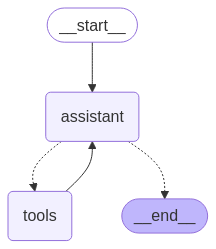

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
messages = [HumanMessage(content="Divide 6790 by 5")]

messages = react_graph.invoke({"messages": messages,"input_file":None})

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [ ]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide 6790 by 5
================================== Ai Message ==================================
Tool Calls:
  divide (call_s0G5ewtIQyHUCOv0fClsCpgh)
 Call ID: call_s0G5ewtIQyHUCOv0fClsCpgh
  Args:
    a: 6790
    b: 5
================================= Tool Message =================================
Name: divide

1358.0
================================== Ai Message ==================================

The result of dividing 6790 by 5 is 1358.0.


## Training program
MR Wayne left a note with his training program for the week. I came up with a recipe for dinner leaft in a note.

you can find the document [HERE](https://huggingface.co/datasets/agents-course/course-images/blob/main/en/unit2/LangGraph/Batman_training_and_meals.png), so download it and upload it in the local folder.

![Training](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit2/LangGraph/Batman_training_and_meals.png)

In [ ]:
messages = [HumanMessage(content="According the note provided by MR wayne in the provided images. What's the list of items I should buy for the dinner menu ?")]

messages = react_graph.invoke({"messages": messages,"input_file":"Batman_training_and_meals.png"})

In [ ]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

According the note provided by MR wayne in the provided images. What's the list of tiems I should buy for the dinner menu ?
================================== Ai Message ==================================
Tool Calls:
  extract_text (call_JalVBOR82hwRknFcplnLoTtG)
 Call ID: call_JalVBOR82hwRknFcplnLoTtG
  Args:
    img_path: Batman_training_and_meals.png
================================= Tool Message =================================
Name: extract_text

TRAINING SCHEDULE
For the week of 2/20-2/26

SUNDAY 2/20
MORNING
30 minute jog
30 minute meditation

EVENING
clean and jerk lifts—3 reps/8 sets. 262 lbs.
5 sets metabolic conditioning:
10 mile run
12 kettlebell swings
12 pull-ups
30 minutes flexibility
30 minutes sparring

MONDAY 2/21
MORNING
30 minute jog
30 minutes traditional kata (focus on Japanese forms)

EVENING
5 sets 20 foot rope climb
30 minutes gymnastics (work on muscle ups in
particular)
high ba